# Στοχαστικές Διεργασίες και Βελτιστοποίηση στη Μηχανική Μάθηση

## 4ο Εργαστήριο - *Ο Αλγόριθμος Metropolis-Hastings*

- Ονομ/νυμο: Χρήστος Νίκου
- AM: 03400146
- Ιδιότητα: Μεταπτυχιακός φοιτητής Επιστήμης Δεδομένων και Μηχανικής Μάθησης (ΕΔΕΜΜ)
- Ηλεκτρονική Διεύθυνση: christosnikou@mail.ntua.gr / chrisnick92@gmail.com

<h1><b>Ο Αλγόριθμος <i>Metropolis-Hastings</i></b></h1>

<b>Σημείωση</b>: Η άσκηση αυτή έχει βασιστεί στο άρθρο που μπορεί να βρεθεί <a href="https://www.tweag.io/blog/2019-10-25-mcmc-intro1/">εδώ</a>. Στο συγκεκριμένο άρθρο μπορεί να βρεθεί μια πιο αναλυτική εισαγωγή στις μεθόδους <b><i>Monte Carlo Markov Chain</i> (<i>MCMC</i>)</b> και στον αλγόριθμο <b><i>Metropolis-Hastings</i></b>, καθώς και συνοδευτικά άρθρα για πιο προχωρημένα ζητήματα.

Στην άσκηση αυτή θα μελετήσετε τον αλγόριθμο <b><i>Metropolis-Hastings</i></b>. Συγκεκριμένα, θα χρησιμοποιήσετε τον αλγόριθμο για να λάβετε δειγματικά στοιχεία (sampling points) από μία <b><i>τυπική κανονική κατανομή</i> (<i>standard normal distribution</i>)</b>, δηλαδή μία κανονική κατανομή συνεχούς τυχαίας μεταβλητής με μέση τιμή $μ=0$ και τυπική απόκλιση $σ=1$. 

Ως <b><i>proposal conditional density</i></b> θα λάβετε μία ομοιόμορφη κατανομή στο διάστημα $(-\frac{Δ}{2}, \frac{Δ}{2})$. Αφού η <b><i>proposal conditional density</i></b> που θα χρησιμοποιήσετε είναι μία συμμετρική κατανομή, ο αλγόριθμος <b><i>Metropolis-Hastings</i></b> θα λάβει την απλοποιημένη μορφή του, δηλαδή η πιθανότητα να πραγματοποιήσετε μία μετάβαση από την κατάσταση $x_{old}$ στην κατάσταση $x_{new}$ για μια κατανομή $π$ θα δίνεται από τον παρακάτω τύπο:

$$
p_{accept}(x_{new} | x_{old}) = min\left[1, \frac{π(x_{new})}{π(x_{old})}\right]
$$

Αναλυτικές οδηγίες σχετικά με το πώς προκύπτει ο παραπάνω τύπος περιλαμβάνονται στις διαφάνειες του μαθήματος, αλλά και στο άρθρο πάνω στο οποίο βασίστηκε η συγκεκριμένη άσκηση.

<h3><b>Υλοποίηση του Αλγορίθμου <i>Metropolis-Hastings</i> σε Python</b></h3>

Αρχικά, θα ορίσουμε τη μέθοδο <b><i>log_prob</i></b>, η οποία θα χρησιμοποιηθεί για τον υπολογισμό τιμών από την <b><i>τυπική κανονική κατανομή</i></b>. Να σημειωθεί ότι λαμβάνεται ο λογάριθμος της κατανομής αυτής. Ο λογάριθμος αυτός μπορεί να υπολογιστεί εύκολα από τον τύπο της <b><i>τυπικής κανονικής κατανομής</i></b>, που είναι διαθέσιμος από <a href="https://en.wikipedia.org/wiki/Normal_distribution#Standard_normal_distribution">εδώ</a>. Λόγοι για τους οποίους προτιμάται αυτή η μορφή μπορούν να αναζητηθούν <a href="https://stats.stackexchange.com/questions/137710/metropolis-hastings-using-log-of-the-density">εδώ</a>. Τέλος, οι σταθερές μπορούν να αγνοηθούν από τον τύπο με ασφάλεια λόγω της μορφή του αλγορίθμου <b><i>Metropolis-Hastings</i></b>.

In [1]:
import numpy as np

In [2]:
# custom function to measure time
import time

def timer(tic):
    timer = time.time()-tic
    print(f"{timer//60} Min(s) {timer % 60:.3f} sec(s)")

In [3]:
def log_prob(x):
     return -0.5 * np.float64(x ** 2)

Στη συνέχεια, ορίζουμε τη μέθοδο <b><i>proposal</i></b>, η οποία θα χρησιμοποιηθεί για τον υπολογισμό τιμών από την ομοιόμορφη κατανομή, η οποία αποτελεί την <b><i>proposal conditional density</i></b>.

In [4]:
def proposal(x, stepsize):
    return np.random.uniform(low=x - 0.5 * stepsize, 
                             high=x + 0.5 * stepsize, 
                             size=x.shape)

Η πιθανότητα αποδοχής μιας νέας κατάστασης $x_{new}$ δεδομένης της τρέχουσας κατάστασης $x_{old}$ υπολογίζεται από τη παρακάτω μέθοδο. Να σημειωθεί πως στη συγκεκριμένη μέθοδο, ο τύπος $p_{accept}$ που δόθηκε παραπάνω έχει τροποποιηθεί κατάλληλα, ώστε να μην εμφανίζονται αρνητικές τιμές. Οι δύο μορφές του τύπου είναι ισοδύναμες, καθώς σημασία έχει η σύγκριση δύο τιμών και όχι οι ακριβείς τιμές, όπως φαίνεται από τον παραπάνω τύπο.

In [5]:
def p_acc_MH(x_new, x_old, log_prob):
    return min(1, np.exp(log_prob(x_new) - log_prob(x_old)))

Στη συνέχεια, υλοποιείται η μέθοδος με την οποία θα αποφασίζει ο αλγόριθμος <b><i>Metropolis-Hastings</i></b> εάν θα γίνει δεκτό ένα προτεινόμενο βήμα.

In [6]:
def sample_MH(x_old, log_prob, stepsize):
    x_new = proposal(x_old, stepsize)
    accept = np.random.random() < p_acc_MH(x_new, x_old, log_prob)
    if accept:
        return accept, x_new
    else:
        return accept, x_old

Τέλος, ορίζεται μία συνάρτηση που μετράει πόσες φορές έγιναν αποδεκτά τα προτεινόμενα βήματα.

In [7]:
def build_MH_chain(init, stepsize, n_total, log_prob):

    n_accepted = 0
    chain = [init]

    for _ in range(n_total):
        accept, state = sample_MH(chain[-1], log_prob, stepsize)
        chain.append(state)
        n_accepted += accept
    
    acceptance_rate = n_accepted / float(n_total)
    
    return chain, acceptance_rate

<h3><b>Ερωτήματα (Μέρος Α)</b></h3>

<ul>
<li>Με ποιον τρόπο αποφασίζει ο αλγόριθμος <b><i>Metropolis-Hastings</i></b> εάν θα γίνει δεκτό ένα προτεινόμενο βήμα; Να εξηγήσετε συνοπτικά βάσει των παραπάνω μεθόδων.</li>
<li>Με ποιον τρόπο αξιοποιούνται οι <b><i>αλυσίδες Markov</i> (<i>Markov Chains</i>)</b> από τον αλγόριθμο <b><i>Metropolis-Hastings</i></b> για τη λήψη τυχαίων δειγματικών σημείων από μία κατανομή πιθανοτήτων;</li>
<li>Ο αλγόριθμος <b><i>Metropolis-Hastings</i></b> χρησιμοποιείται για τη λήψη τυχαίου δείγματος από μία κατανομή πιθανοτήτων για την οποία είναι αδύνατο να λάβουμε τέτοια δειγματικά στοιχεία λόγω αδυναμίας πλήρους καταγραφής του δειγματικού χώρου ή/και υπολογισμού κάποιας <b><i>σταθεράς κανονικοποίησης</i></b> που εμφανίζεται στην κατανομή. Έτσι, λαμβάνεται ως <b><i>κατανομή στόχος</i></b> μία κατανομή που έχει γνωστή μορφή, ανάλογη με την κατανομή από την οποία θέλουμε να λάβουμε τα δειγματικά στοιχεία. Με ποιον τρόπο καταφέρνει ο αλγόριθμος <b><i>Metropolis-Hastings</i></b> να δώσει αποτελέσματα παρά το γεγονός ότι αγνοεί τη <b><i>σταθερά κανονικοποίησης</i></b>;
</ul>

<h3> <b> Μέρος Α </b> </h3>

><b>1. </b>*Με ποιον τρόπο αποφασίζει ο αλγόριθμος <b>Metropolis-Hastings</b> εάν θα γίνει δεκτό ένα προτεινόμενο βήμα; Να εξηγήσετε συνοπτικά βάσει των παραπάνω μεθόδων.*

Ο τρόπος με τον οποίο ο αλγόριθμος αποφασίζει εάν θα γίνει δεκτό ένα προτεινόμενο βήμα είναι μέσω της συνάρτησης `sample_MH` μέσω της μεταβλητής `accept`. Αρχικά, επιλέγεται μέσω της συνάρτησης `proposal` εκλέγεται το πιθανό νέο δειγματικό σημείο και αποθηκεύεται στη μεταβλητή `x_new`. Το σημείο `x_new` επιλέγεται ομοιόμορφα απ' το διάστημα 
$$\biggl(x_{old} - \frac{stepsize}{2},x_{old}+\frac{stepsize}{2}\biggr),$$
όπου $x_{old}$ είναι το δειγματικό σημείο του προηγούμενου βήματος και stepsize μια υπερπαράμετρος η οποία δείχνει το βήμα της επιλογής. Εν συνεχεία, μέσω της συνάρτησης `p_acc_MH` υπολογίζεται η πιθανότητα αποδοχής $p_{acc}$ (acceptance). Η πιθανότητα αποδοχής δίνεται μέσω της
$$p_{acc} = \min\biggl\{1,  \exp\bigl(-\frac{1}{2}x_{new}^2 + \frac{1}{2}x_{old}^2\bigr)\biggr\}.$$

Τέλος, το αν θα αποδεχτούμε το νέο δειγματικό σημείο εξαρτάται από την τιμή της μεταβλητής `accept`. Σε περίπτωση που η τιμή της είναι `True` αποδεχόμαστε το νέο δειγματικό σημείο ενώ στην περίπτωση που η μεταβλητή παίρνει την τιμή `False` το απορρίπτουμε. Η ένδειξη της τιμής εξαρτάται απ' την αληθοτιμή της ανίσωσης `np.random.random() < p_acc_MH(x_new, x_old, log_prob)`.

><b>2. </b>*Με ποιον τρόπο αξιοποιούνται οι αλυσίδες <b>Markov (Markov Chains)</b> από τον αλγόριθμο Metropolis-Hastings για τη λήψη τυχαίων δειγματικών σημείων από μία κατανομή πιθανοτήτων;*

Ο τρόπος με τον οποίο αξιοποιούνται οι αλυσίδες *Markov* από τον αλγόριθμο *Metropolis-Hastings* είναι ότι η δειγματοληψία ενός σημείου εξαρτάται από το προηγούμενο δειγματικό σημείο. Στη συγκεκριμένη υλοποίηση, όπως αναφέραμε και προηγουμένως, επιλέγουμε ένα σημείο ομοιόμορφα από το διάστημα 
$$\tag{1}\biggl(x_{old} - \frac{stepsize}{2}, x_{old} + \frac{stepsize}{2}\biggr),$$
με πιθανότητα αποδοχής 
$$P_{acc} = \min\biggl\{1, exp\bigl(-\frac{1}{2}x_{new}^2+\frac{1}{2}x_{old}^2\bigr)\biggr\}.$$
Έτσι, η πιθανότητα μετάβασης από το σημείο $x_{old}$ στο νέο δειγματικό σημείο $x_{new}$ δίνεται μέσω της $T(x_{new}\,|\,x_{old}) = q(x_{new}\,|\,x_{old})\cdot P_{acc},$
όπου $q(x_{new}\,|\,x_{old})$ είναι η ομοιόμορφη κατανομή στο διάστημα της $(1)$. Μέσω της προηγούμενης σχέσης γίνεται εμφανής η εξάρτηση που υπάρχει μεταξύ της επιλογής του νέου δειγματικού σημείου από το προηγούμενο. Αυτή η ιδιότητα είναι χαρακτηριστική στις Μαρκοβιανές αλυσίδες και είναι γνωστή ως η αμνήμονη ιδιότητα. Στη γενικότερη μορφή του αλγορίθμου δειγματοληψίας *Metropolis-Hastings* ο γενικός τύπος που εκφράζει την εξάρτηση επιλογής του επόμενο σημείου απ' το προηγούμενο σημείο λαμβάνει τη μορφή $T(x_{i+1}\,|\, x_{i}) = q(x_{i+1}\,|\,x_{i})\cdot P_{acc}(x_{i+1}\,|\,x_{i})$, όπου $q$ είναι μια προτεινόμενη κατανομή επιλογής (ομοιόμορφη στη συγκεκριμένη υλοποίηση). Επιπλέον, θέλουμε να ικανοποιείται και η απαίτηση η Μαρκοβιανή αλυσίδα να έχει στάσιμη κατανομή την κατανομή $\pi$ από την οποία δειγματοληπτούμε. Μια τέτοια απαίτηση μας εξασφαλίζει η σχέση
$$\pi(x_i)\cdot T(x_{i+1}\,|\,x_{i}) = \pi(x_{i+1})\cdot T(x_{i}\,|\,x_{i+1}),$$
την οποία ικανοποιούν οι πυρήνες μετάβασης $T$ στους αλγορίθμους τύπου *MCMC*.

><b>3. </b> *Ο αλγόριθμος <b>Metropolis-Hastings</b> χρησιμοποιείται για τη λήψη τυχαίου δείγματος από μία κατανομή πιθανοτήτων για την οποία είναι αδύνατο να λάβουμε τέτοια δειγματικά στοιχεία λόγω αδυναμίας πλήρους καταγραφής του δειγματικού χώρου ή/και υπολογισμού κάποιας σταθεράς κανονικοποίησης που εμφανίζεται στην κατανομή. Έτσι, λαμβάνεται ως κατανομή στόχος μία κατανομή που έχει γνωστή μορφή, ανάλογη με την κατανομή από την οποία θέλουμε να λάβουμε τα δειγματικά στοιχεία. Με ποιον τρόπο καταφέρνει ο αλγόριθμος <b>Metropolis-Hastings</b> να δώσει αποτελέσματα παρά το γεγονός ότι αγνοεί τη σταθερά κανονικοποίησης;*

Στη γενική μορφή του αλγορίθμου η πιθανότητα αποδοχής $p_{acc}$ δίνεται μέσω της 
$$p_{acc}(x_{i+1}\,|\,x_{i}) = \min\biggl\{1,\frac{\pi(x_{i+1})\cdot q(x_{i+1}\,|\,x_{i})}{\pi(x_{i})\cdot q(x_{i+1}\,|\,x_i)}\biggr\},$$
όπως βλέπουμε εξαιτίας του λόγου $\pi(x_{i+1})/\pi(x_i)$ η σταθερά κανονικοποίησης που εμφανίζεται στην κατανανομή απλοποιείται και έτσι ο αλγόριθμος <b>*Metropolis-Hastings*</b> μπορεί να δώσει αποτελέσματα χωρίς να συμπεριλάβει τη σταθερά κανονικοποίησης.

<h3><b>Δοκιμές του Αλγορίθμου <i>Metropolis-Hastings</i></b></h3>

Το παρακάτω τμήμα κώδικα ασχολείται με την κλήση των παραπάνω μεθόδων και την οπτικοποίηση των αποτελεσμάτων.

In [8]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]
np.random.seed(42)

def plot_samples(chain, log_prob, ax, orientation='vertical', normalize=True,
                 xlims=(-5, 5), legend=True):
    from scipy.integrate import quad
    
    ax.hist(chain, bins=50, density=True, label="MCMC samples",
           orientation=orientation)
    # we numerically calculate the normalization constant of our PDF
    if normalize:
        Z, _ = quad(lambda x: np.exp(log_prob(x)), -np.inf, np.inf)
    else:
        Z = 1.0
    xses = np.linspace(xlims[0], xlims[1], 1000)
    yses = [np.exp(log_prob(x)) / Z for x in xses]
    if orientation == 'horizontal':
        (yses, xses) = (xses, yses)
    ax.plot(xses, yses, label="true distribution")
    if legend:
        ax.legend(frameon=False)

def sample_and_display(init_state, stepsize, n_total, n_burnin, log_prob):
    chain, acceptance_rate = build_MH_chain(init_state, stepsize, n_total, log_prob)
    print("Acceptance rate: {:.3f}".format(acceptance_rate))
    fig, ax = plt.subplots(figsize = (7,5))
    plot_samples([state for state, in chain[n_burnin:]], log_prob, ax)
    ax.set_yticks(())
    plt.show()

Το αποτέλεσμα που περιμένετε να δείτε από τη συγκεκριμένη άσκηση είναι ότι ο αλγόριθμος <b><i>Metropolis-Hastings</i></b> θα σας επιστρέψει δειγματικά στοιχεία τα οποία θα ακολουθούν <b><i>τυπική κανονική κατανομή</i></b>.

Εκτελέστε την παρακάτω μέθοδο για μέγεθος βήματος $Δ = 3.0$ και συνολικό αριθμό βημάτων $10000$. Παρατηρήστε ότι η κατανομή που προκύπτει είναι πολύ κοντά σε μία <b><i>τυπική κανονική</i></b>, ενώ το ποσοστό των βημάτων που έγιναν δεκτά από τον αλγόριθμο <b><i>Metropolis-Hastings</i></b> είναι περίπου $70$%.

Acceptance rate: 0.718


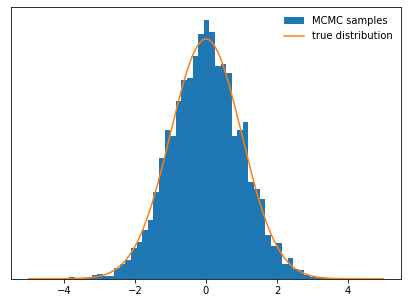

0.0 Min(s) 0.725 sec(s)


In [9]:
tic = time.time()
sample_and_display(np.array([2.0]), 3.0, 10000, 500, log_prob)
timer(tic)

<h3><b>Ερωτήματα (Μέρος Β)</b></h3>

Να επαναλάβετε για $Δ=30$ και συνολικό αριθμό βημάτων $10000$. Τι παρατηρείτε ότι συμβαίνει στην περίπτωση που χρησιμοποιείτε ένα πολύ μεγάλο βήμα, δηλαδή πολύ μεγάλη τιμή για την παράμετρο $Δ$; Να επαναλάβετε για $Δ=300$, $Δ=3000$ και $Δ=30000$, ώστε να επιβεβαιώσετε το συμπέρασμά σας. Σχολιάστε και το ποσοστό των αποδεκτών βημάτων.

### Δ = 30

Acceptance rate: 0.111


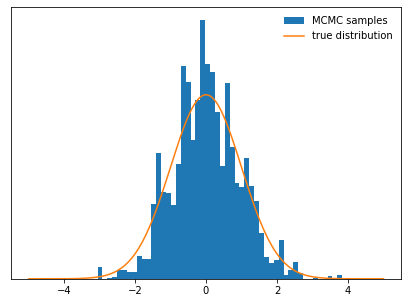

0.0 Min(s) 0.469 sec(s)


In [10]:
tic = time.time()
sample_and_display(np.array([2.0]), 30, 10000, 500, log_prob)
timer(tic)

### Δ = 300

Acceptance rate: 0.011


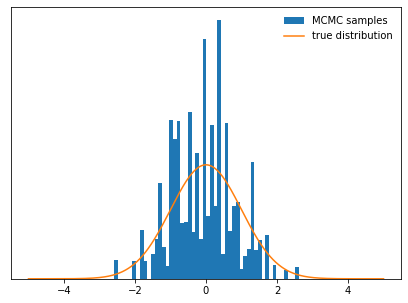

0.0 Min(s) 0.510 sec(s)


In [11]:
tic = time.time()
sample_and_display(np.array([2.0]), 300, 10000, 500, log_prob)
timer(tic)

### Δ = 3000

Acceptance rate: 0.001


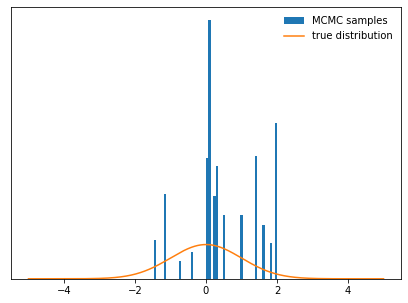

0.0 Min(s) 0.459 sec(s)


In [12]:
tic = time.time()
sample_and_display(np.array([2.0]), 3000, 10000, 500, log_prob)
timer(tic)

### Δ = 30000

Acceptance rate: 0.000


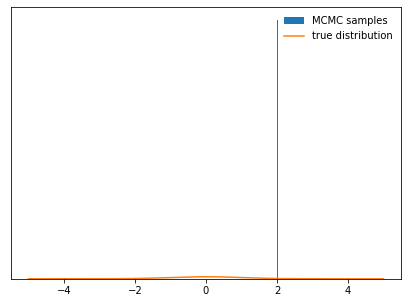

0.0 Min(s) 0.470 sec(s)


In [13]:
tic = time.time()
sample_and_display(np.array([2.0]), 30000, 10000, 500, log_prob)
timer(tic)

> *Τι παρατηρείτε ότι συμβαίνει στην περίπτωση που χρησιμοποιείτε ένα πολύ μεγάλο βήμα, δηλαδή πολύ μεγάλη τιμή για την παράμετρο $Δ$;*

Όπως παρατηρούμε και απ' τα παραπάνω διαγράμματα όσο μεγαλώνει η τιμή του βήματος δειγματοληψίας $Δ$ τόσο μειώνεται το ποσοστό αποδοχής του δειγματικού σημείου και έτσι τελειώνοντας τις επαναλήψεις του αλγορίθμου δεν έχουμε μεγάλο αριθμό έτσι ώστε να ανακτήσουμε την κατανομή. Αυτό είναι λογικό αν κοιτάξουμε πάλι την πιθανότητα αποδοχής η οποία δίνεται από την
$$P_{acc} = \min\biggl\{1, \exp\bigl(-\frac{1}{2}x_{new}^2 + \frac{1}{2}x_{old}^2\bigr)\biggr\}.$$
Όπως βλέπουμε, η ποσότητα 
$$\exp\bigl(-\frac{1}{2}x_{new}^2 + \frac{1}{2}x_{old}^2\bigr) \to 0,$$
καθώς το $|x_{new}|\to +\infty$, με αποτέλεσμα η πιθανότητα αποδοχής να είναι πάντα κοντά στο μηδέν όταν έχουμε μεγάλες τιμές του `x_new`. Έτσι, η μεταβλητή `accept` τις περισσότερες φορές είναι ψευδής με αποτέλεσμα να μην προσθέτονται νέα σημεία κατά τη διάρκεια των επαναλήψεων.

Να επαναλάβετε για $Δ=0.1$, δηλαδή μία πολύ μικρή τιμή για το βήμα. Τι παρατηρείτε; Είναι ικανοποιητικά τα αποτελέσματά σας; Σχολιάστε και το ποσοστό των αποδεκτών βημάτων. Να επαναλάβετε για $Δ=0.01$.

### Δ = 0.1

Acceptance rate: 0.991


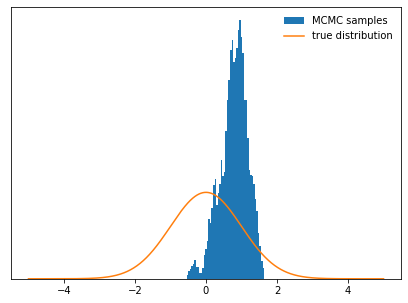

0.0 Min(s) 0.456 sec(s)


In [14]:
tic = time.time()
sample_and_display(np.array([2.0]), 0.1, 10000, 500, log_prob)
timer(tic)

Όπως βλέπουμε απ' το παραπάνω διάγραμμα στη περίπτωση για $Δ=0.1$ έχουμε αρκετά υψηλό ποσοστό αποδοχής. Παρ' όλα αυτά, σε αυτή την περίπτωση όπως βλέπουμε δεν έχουμε καλή δειγματοληψία απ' την κατανομή, δηλαδή, στο παραπάνω σχήμα το ιστόγραμμα των σημείων που έχουμε μετά το πέρας της δειγματοληψίας απέχει απ' το γράφημα της κατανομής. Αυτό είναι λογικό αφού για μικρές τιμές του $Δ$ επιλέγουμε τιμές οι οποίες βρίσκονται πολύ κοντά στο προηγούμενο σημείο $x_{old}$ με αποτέλεσμα να μην έχουμε ικανοποιητικό αριθμό σημείων που να προέρχονται απ' την «ουρά» της κατανομής. Επομένως, για τη περίπτωση που $Δ = 0.1$ δεν έχουμε ιδιαίτερα ικανοποιητικά αποτέλεσματα για $10000$ επαναλήψεις. Παρακάτω βλέπουμε και τη δειγματοληψία που αντιστοιχεί για $Δ = 0.01$ και $10000$ επαναλήψεις.

### Δ = 0.01

Acceptance rate: 0.986


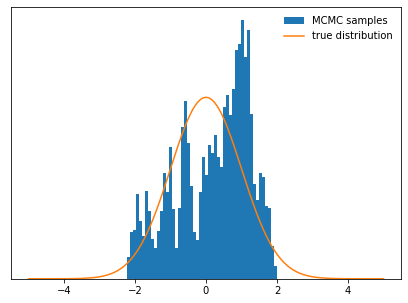

0.0 Min(s) 0.484 sec(s)


In [15]:
tic = time.time()
sample_and_display(np.array([2.0]), 0.1, 10000, 500, log_prob)
timer(tic)

Όπως βλέπουμε και στη περίπτωση για $Δ = 0.01$ έχουμε παρόμοια αποτελέσματα με την περίπτωση του $Δ=0.1$. Και σε αυτή την περίπτωση το ιστόγραμμα της δειγματοληψίας δεν περιγράφει ικανοποιητικά την κατανομή. Επίσης, και σε αυτή την περίπτωση το ποσοστό της αποδοχής είναι αρκετά υψηλό.

Να επαναλάβετε αυξάνοντας το συνολικό αριθμό βημάτων που θα πραγματοποιηθούν σε $500000$. Τι παρατηρείτε σχετικά με την ακρίβεια των αποτελεσμάτων σας, αλλά και το χρόνο εκτέλεσης του αλγορίθμου <b><i>Metropolis-Hastings</i></b>;

Acceptance rate: 0.990


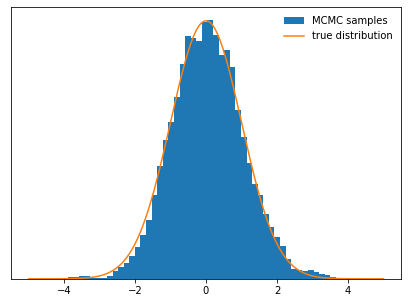

0.0 Min(s) 13.904 sec(s)


In [16]:
tic = time.time()
sample_and_display(np.array([2.0]), 0.1, 500000, 25000, log_prob)
timer(tic)

Όπως βλέπουμε απ' το παραπάνω διάγραμμα η δειγματοληψία είναι αρκετά ικανοποιητική όταν αυξάνουμε τον αριθμό των επαναλήψεων από $10000$ σε $500000$. Παρ' όλα αυτά, με των αριθμό των επαναλήψεων αυξήθηκε και ο αριθμός εκτέλεσης του αλγορίθμου καθώς σε όλες τις προηγούμενες περιπτώσεις ο χρόνος εκτέλεσης ήταν κάτω του $1$ δευτερολέπτου, ενώ σε αυτή την περίπτωση ολοκληρώθηκε σε $13$ δευτερόλεπτα.

Η συνάρτηση <b><i>sample_and_display</i></b> περιλαμβάνει το n_burnin ως τέταρτο όρισμα. Ποια είναι η χρησιμότητα του ορίσματος αυτού; Δοκιμάστε τις παρακάτω τιμές:
<ul>
<li>$Δ=0.1$, αριθμός βημάτων $1000$ και n_burnin=$10$.</li>
<li>$Δ=0.1$, αριθμός βημάτων $500000$ και n_burnin=$490000$.</li>
</ul>
Τι παρατηρείτε;

>*Η συνάρτηση <b>sample_and_display</b> περιλαμβάνει το <b>n_burnin</b> ως τέταρτο όρισμα. Ποια είναι η χρησιμότητα του ορίσματος αυτού;*

Το όρισμα `n_burnin` της συνάρτησης `sample_and_display` εκφράζει το σημείο απ' το οποίο και πέρα επιλέγουμε να κρατήσουμε τα δείγματα που έχουν προκύψει κατά την εκτέλεση του αλγορίθμου *Metropolis-Hastings*. Ο λόγος για τον οποίο χρησιμοποιείται το συγκεκριμένο όρισμα είναι επειδή η σύγκλιση της Μαρκοβιανής αλυσίδας που κατασκευάζουμε κατά τη διαδικασία του αλγορίθμου αρχίζει να συγκλίνει στην αρχική κατανομή μετά από κάποιο αριθμό βημάτων. Επομένως, διαλέγουμε να κρατήσουμε τα σημεία τα οποία έχουν προκύψει μετά από κάποιο αριθμών δειγματοληψειών έτσι ώστε να έχουμε πιο ακριβή αποτελέσματα τα οποία να περιγράφουν σε καλύτερο βαθμό την κατανομή που έχουμε ως αναφορά. Παρακάτω βλέπουμε και τα αποτελέσματα του αλγορίθμου για διαφορετικές τιμές της παραμέτρου `n_burnin`.

### Δ=0.1 , αριθμός βημάτων  1000  και n_burnin= 10 .

Acceptance rate: 0.981


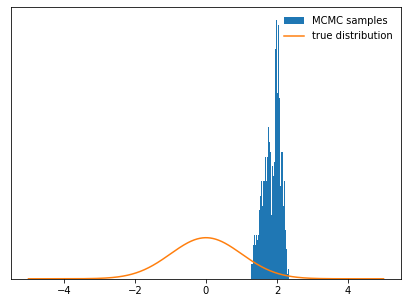

0.0 Min(s) 0.189 sec(s)


In [17]:
tic = time.time()
sample_and_display(np.array([2.0]), 0.1, 1000, 10, log_prob)
timer(tic)

Όπως βλέπουμε στη περίπτωση που η παράμετρος `n_burnin` παίρνει μικρές τιμές η δειγματοληψία δεν έχει ακριβή αποτελέσματα και αυτό οφείλεται στο γεγονός ότι η Μαρκοβιανή αλυσίδα δεν έχει ξεκινήσει να συγκλίνει προς την κατανομή αναφοράς από το 10ο βήμα.

### Δ=0.1 , αριθμός βημάτων  500000  και n_burnin= 490000 .|

Acceptance rate: 0.991


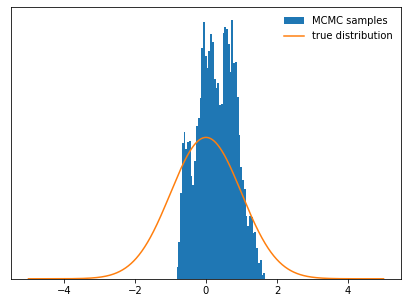

0.0 Min(s) 12.349 sec(s)


In [18]:
tic = time.time()
sample_and_display(np.array([2.0]), 0.1, 500000, 490000, log_prob)
timer(tic)

Όπως βλέπουμε σε αυτή την περίπτωση που έχουμε μεγαλύτερη τιμή για την παράμετρο `n_burnin` έχουμε καλύτερα αποτελέσματα απ'την προηγούμενη περίπτωση. Παρ' όλα αυτά, και σε αυτή την περίπτωση το αποτέλεσμα της δειγματοληψίας δεν είναι ιδιαιτέρα ικανοποιητικό καθώς η τιμή του $Δ = 0.1$ είναι πολύ μικρή και η τιμή της παραμέτρου `n_burnin` να είναι πολύ μεγαλή με αποτέλεσμα να μην λαμβάνουμε αρκετά δειγματικά σημεία μετά το πέρας της δειγματοληψίας. Επομένως, ο ιδανικός συνδυασμός των παραμέτρων για τη συγκεκριμένη υλοποιήση είναι ο `stepsize = 3, n_total = 10000, n_burnin = 500` και `stepsize = 0.1, n_total = 500000, n_burnin = 25000`, παρόλο που στη δεύτερη περίπτωση έχουμε λίγο μεγαλύτερο χρόνο εκτέλεσης.